In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import pickle

In [50]:
data = pd.read_csv('/content/Tree_Inventory_20250211.csv', low_memory=False)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133217 entries, 0 to 133216
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Editing                         133217 non-null  object 
 1   Botanical Name                  133217 non-null  object 
 2   Common Name                     133217 non-null  object 
 3   DBH                             133217 non-null  float64
 4   Total Yearly Eco Benefits ($)   133217 non-null  float64
 5   Stormwater Benefits ($)         133217 non-null  float64
 6   Stormwater Gallons Saved        133217 non-null  float64
 7   Greenhouse CO2 Benefits ($)     133217 non-null  float64
 8   CO2 Avoided (in lbs.)           133217 non-null  float64
 9   CO2 Sequestered (in lbs.)       133217 non-null  float64
 10  Energy Benefits ($)             133217 non-null  float64
 11  kWh Saved                       133217 non-null  float64
 12  Therms Saved    

In [52]:
data.describe()

,DBH,Total Yearly Eco Benefits ($),Stormwater Benefits ($),Stormwater Gallons Saved,Greenhouse CO2 Benefits ($),CO2 Avoided (in lbs.),CO2 Sequestered (in lbs.),Energy Benefits ($),kWh Saved,Therms Saved,Air Quality Benefits ($),Pollutants Saved (in lbs.),Property Benefits ($),Leaf Surface Area (in sq. ft.),Address,Site,Latitude,Longitude,Site ID
count,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000,133217.000000
mean,7.308844,58.416929,3.946915,493.362563,0.306664,59.305223,46.626216,26.192063,39.926054,14.629488,2.552868,0.409115,25.418646,42.245516,1244.725418,1.431311,42.908862,-78.846771,66692.484045
std,10.110349,76.913617,7.486057,935.740521,0.646882,118.124378,111.586800,36.323506,58.193547,20.034156,4.921170,0.786854,33.999399,56.506483,28978.749166,4.129142,0.122206,0.218068,38502.472392
min,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-78.911907,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,1.000000,42.890996,-78.871449,33359.000000
50%,2.000000,15.350000,0.240000,30.110000,0.010000,1.170000,0.770000,4.050000,4.430000,2.430000,0.090000,0.010000,8.990000,14.940000,179.000000,1.000000,42.913241,-78.846552,66688.000000
75%,13.000000,103.250000,4.710000,588.570000,0.200000,36.700000,26.580000,48.760000,73.650000,27.470000,2.210000,0.340000,46.970000,78.060000,414.000000,1.000000,42.936058,-78.821594,100002.000000
max,508.000000,469.300000,68.280000,8534.550000,7.600000,941.650000,1844.070000,170.640000,329.780000,88.380000,44.760000,6.370000,241.990000,402.180000,999999.000000,206.000000,42.965551,0.000000,136329.000000


In [53]:
data = data.dropna()
for column in data.columns:
        most_frequent_dtype = data[column].map(type).mode()[0]
        data = data[data[column].map(type) == most_frequent_dtype]

In [54]:
string_cols = []
for cols in data.columns:
    if data[cols].dtype == 'object':
        string_cols.append(cols)
data[string_cols] = data[string_cols].apply(lambda x: x.str.lower())
data.head()

,Editing,Botanical Name,Common Name,DBH,Total Yearly Eco Benefits ($),Stormwater Benefits ($),Stormwater Gallons Saved,Greenhouse CO2 Benefits ($),CO2 Avoided (in lbs.),CO2 Sequestered (in lbs.),...,Street,Side,Site,Council District,Park Name,Latitude,Longitude,Site ID,Location,location
0,buffalo,vacant,vacant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,heath st,front,1,university,0,42.954105,-78.828073,68809,"(42.95410530111608, -78.82807286423107)",point (-78.82807286423107 42.95410530111608)
1,buffalo,vacant,vacant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,tyler st,side,1,university,0,42.953676,-78.830928,68890,"(42.95367554326824, -78.83092765717774)",point (-78.83092765717774 42.95367554326824)
2,buffalo,vacant,vacant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,tyler st,front,1,university,0,42.952119,-78.828007,69112,"(42.95211855076942, -78.82800662841616)",point (-78.82800662841616 42.95211855076942)
3,buffalo,vacant,vacant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,croy av,front,1,university,0,42.946709,-78.798992,130082,"(42.94670885005654, -78.79899248638527)",point (-78.79899248638527 42.94670885005654)
4,buffalo,vacant,vacant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,weston av,in_lot,1,university,0,42.928469,-78.803656,128018,"(42.92846923591323, -78.80365607542926)",point (-78.80365607542926 42.92846923591323)


In [55]:
Q1 = data.select_dtypes(include='number').quantile(0.25)
Q3 = data.select_dtypes(include='number').quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = pd.DataFrame(False, index=data.index, columns=data.columns)
for column in data.select_dtypes(include='number').columns:
    outliers[column] = (data[column] < lower_bound[column]) | (data[column] > upper_bound[column])
for column in data.select_dtypes(include='number').columns:
    data[column] = data[column].where(~outliers[column], data[column].median())
data = data.drop('location', axis=1)
print("Tree Inventory Data \n", data.describe())

Tree Inventory Data 
                  DBH  Total Yearly Eco Benefits ($)  Stormwater Benefits ($)  \
count  133216.000000                  133216.000000            133216.000000   
mean        6.279998                      51.979753                 1.565294   
std         8.285389                      67.362240                 2.761162   
min       -10.000000                       0.000000                 0.000000   
25%         0.000000                       0.000000                 0.000000   
50%         2.000000                      15.350000                 0.240000   
75%        12.000000                      98.810000                 1.880000   
max        32.000000                     257.850000                11.740000   

       Stormwater Gallons Saved  Greenhouse CO2 Benefits ($)  \
count             133216.000000                133216.000000   
mean                 195.678875                     0.039764   
std                  345.136420                     0.083439   
m

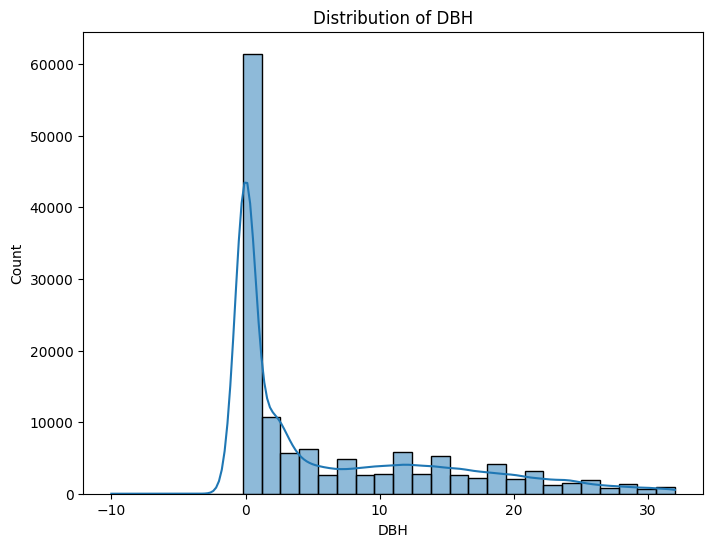

In [56]:
plt.figure(figsize=(8, 6))
sns.histplot(data['DBH'], bins=30, kde=True)
plt.title('Distribution of DBH')
plt.show()

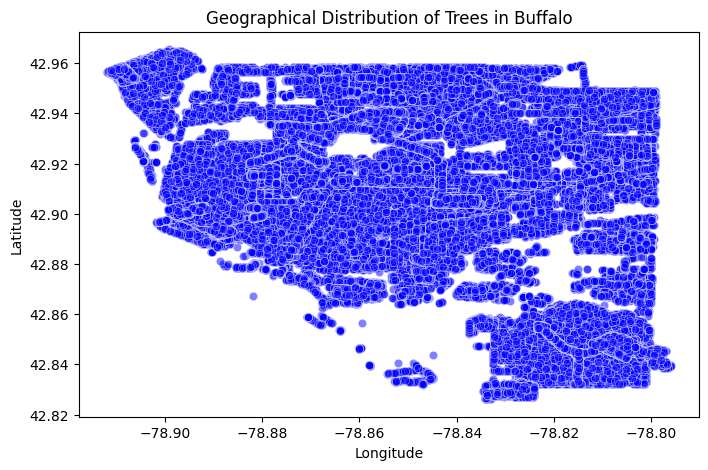

In [57]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=data["Longitude"], y=data["Latitude"], alpha=0.5, color="blue")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical Distribution of Trees in Buffalo")
plt.show()

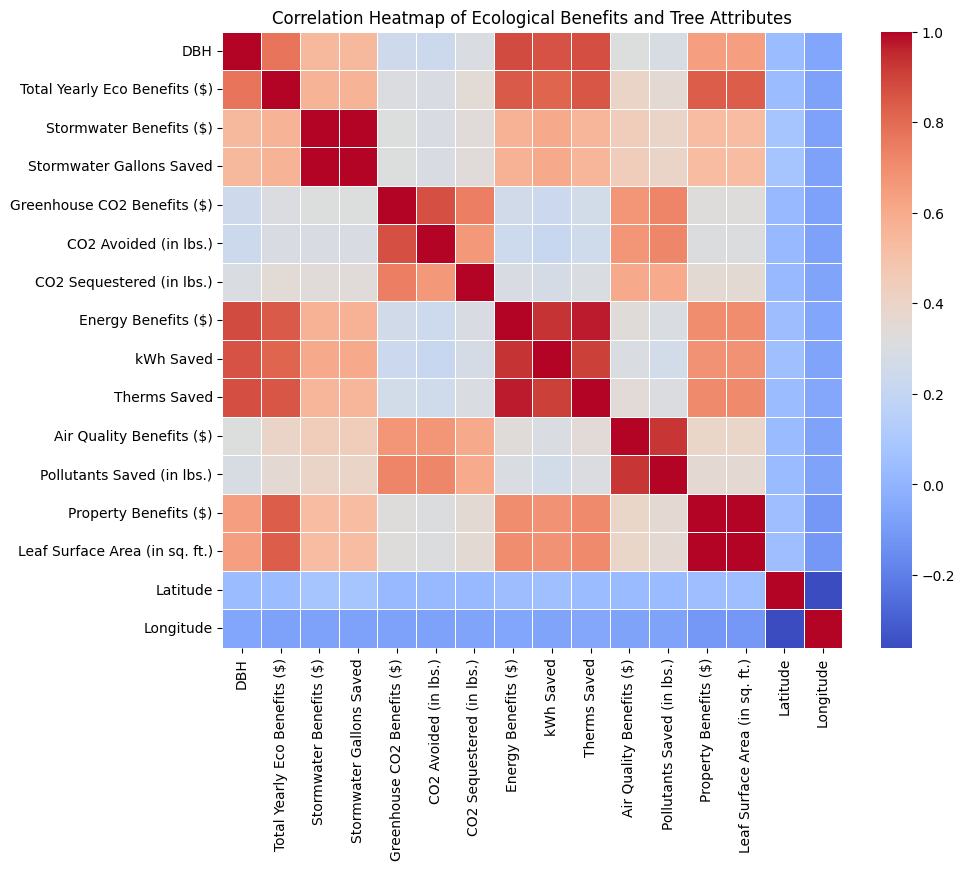

In [58]:
plt.figure(figsize=(10, 8))
corr_matrix = data.select_dtypes(include=["float64"]).corr()
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap of Ecological Benefits and Tree Attributes")
plt.show()

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133216 entries, 0 to 133216
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Editing                         133216 non-null  object 
 1   Botanical Name                  133216 non-null  object 
 2   Common Name                     133216 non-null  object 
 3   DBH                             133216 non-null  float64
 4   Total Yearly Eco Benefits ($)   133216 non-null  float64
 5   Stormwater Benefits ($)         133216 non-null  float64
 6   Stormwater Gallons Saved        133216 non-null  float64
 7   Greenhouse CO2 Benefits ($)     133216 non-null  float64
 8   CO2 Avoided (in lbs.)           133216 non-null  float64
 9   CO2 Sequestered (in lbs.)       133216 non-null  float64
 10  Energy Benefits ($)             133216 non-null  float64
 11  kWh Saved                       133216 non-null  float64
 12  Therms Saved         

In [60]:
target_column = 'Total Yearly Eco Benefits ($)'
y = data[target_column]
median_benefit = y.median()
y = (y >= median_benefit).astype(int)
data = data.drop(target_column, axis=1)
X = data
X = X.select_dtypes(include=np.number)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Training data shape: (93251, 18)
Validation data shape: (19982, 18)
Test data shape: (19983, 18)


In [61]:
class TreeEcologicalBenefitClassifier(nn.Module):
    def __init__(self, input_size):
        super(TreeEcologicalBenefitClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x


In [62]:
input_size = X_train.shape[1]
model = TreeEcologicalBenefitClassifier(input_size)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (torch.round(outputs) == labels).sum().item()
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / len(train_dataset))
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            val_correct += (torch.round(outputs) == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / len(val_dataset))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")
print(f"Training time: {time.time() - start_time} seconds")
with open('a0_bonus_mythrish.pkl', 'wb') as f:
    pickle.dump(model.state_dict(), f)
model.eval()
test_loss, test_correct = 0, 0
predictions, actuals, probabilities = [], [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        test_correct += (torch.round(outputs) == labels).sum().item()
        predictions.extend(torch.round(outputs).cpu().numpy())
        actuals.extend(labels.cpu().numpy())
        probabilities.extend(outputs.cpu().numpy())
predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()
probabilities = np.array(probabilities).flatten()
accuracy = accuracy_score(actuals, predictions)
precision = precision_score(actuals, predictions)
recall = recall_score(actuals, predictions)
f1 = f1_score(actuals, predictions)
print(f"Test Loss (BCE): {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
test_accuracy = accuracy
test_accuracies = [test_accuracy] * num_epochs
test_loss_value = test_loss / len(test_loader)
test_losses = [test_loss_value] * num_epochs

Epoch 1/10, Train Loss: 0.0359, Val Loss: 0.0126, Train Acc: 0.9868, Val Acc: 0.9963
Epoch 2/10, Train Loss: 0.0159, Val Loss: 0.0105, Train Acc: 0.9947, Val Acc: 0.9970
Epoch 3/10, Train Loss: 0.0132, Val Loss: 0.0130, Train Acc: 0.9958, Val Acc: 0.9944
Epoch 4/10, Train Loss: 0.0121, Val Loss: 0.0115, Train Acc: 0.9964, Val Acc: 0.9958
Epoch 5/10, Train Loss: 0.0114, Val Loss: 0.0112, Train Acc: 0.9968, Val Acc: 0.9958
Epoch 6/10, Train Loss: 0.0107, Val Loss: 0.0086, Train Acc: 0.9968, Val Acc: 0.9974
Epoch 7/10, Train Loss: 0.0104, Val Loss: 0.0087, Train Acc: 0.9970, Val Acc: 0.9972
Epoch 8/10, Train Loss: 0.0102, Val Loss: 0.0075, Train Acc: 0.9969, Val Acc: 0.9976
Epoch 9/10, Train Loss: 0.0094, Val Loss: 0.0077, Train Acc: 0.9972, Val Acc: 0.9974
Epoch 10/10, Train Loss: 0.0099, Val Loss: 0.0218, Train Acc: 0.9970, Val Acc: 0.9915
Training time: 67.39834690093994 seconds
Test Loss (BCE): 0.0223
Test Accuracy: 99.04%
Precision: 0.9842
Recall: 0.9964
F1 Score: 0.9903


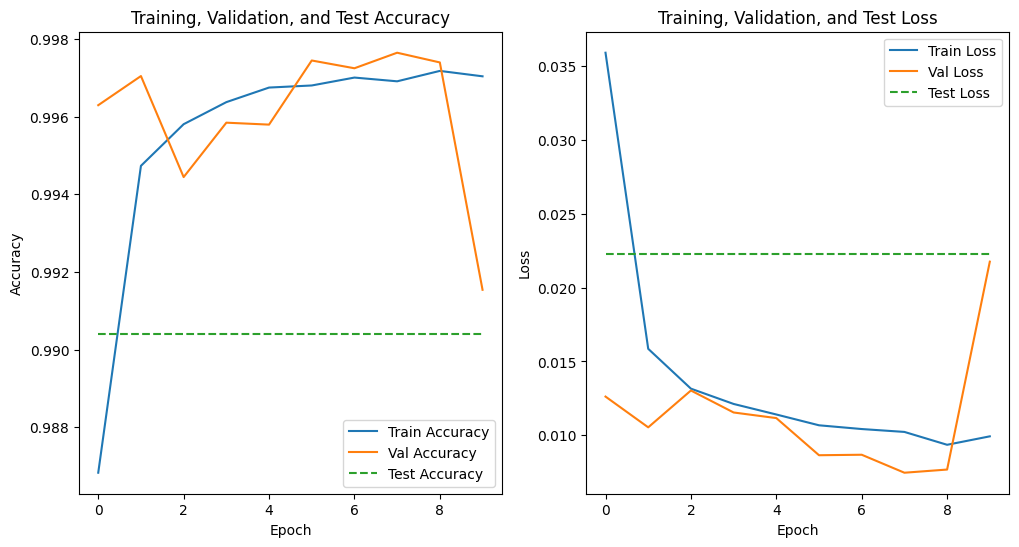

In [63]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()